## HW-1 author: Pouya Bastani 
In this project we used OpenCV and SKLearn modules for process the image and K-NN Method as Classifier

# Detecting the number
- Adding OpenCV module 
- Open picture
- Divide Picture to 4 Zones
- Calculate the Density of white pixels in each Zone
- Save Data in a list

In [1]:
# Import the Module OpenCV and Numpy
import cv2
import numpy as np

# Read the image
image = cv2.imread('hasht_test.png', cv2.IMREAD_GRAYSCALE)

# Get the dimensions of the image
height, width = image.shape
for i in range(width):
    for j in range(height):
        if (image[j][i] > 100 ):
            image[j][i] = 255

        else:
            image[j][i] = 0

# Define coordinates to split the image into four zones
x_mid = width // 2
y_mid = height // 2

# Crop the image into four zones
zone1 = image[0:y_mid, 0:x_mid]             # Top left zone
zone2 = image[0:y_mid, x_mid:width]         # Top right zone
zone3 = image[y_mid:height, 0:x_mid]        # Bottom left zone
zone4 = image[y_mid:height, x_mid:width]    # Bottom right zone

#Calculate the density of black pixels in each zones
density_of_white_pix_zone1 = np.sum(zone1 == 255) / (zone1.shape[0] * zone1.shape[1])
density_of_white_pix_zone2 = np.sum(zone2 == 255) / (zone2.shape[0] * zone2.shape[1])
density_of_white_pix_zone3 = np.sum(zone3 == 255) / (zone3.shape[0] * zone3.shape[1])
density_of_white_pix_zone4 = np.sum(zone4 == 255) / (zone4.shape[0] * zone4.shape[1])

input_number = np.array((density_of_white_pix_zone1,density_of_white_pix_zone2,
                         density_of_white_pix_zone2,density_of_white_pix_zone4))

input_number = input_number.reshape(1,4)

# Wait for a key press and close all windows
cv2.waitKey(0)
cv2.destroyAllWindows()

## Reading Data of cdb File

In [2]:
cdb_file_path = "Test 20000.cdb"
    # Open the CDB file for reading
with open(cdb_file_path, 'rb') as f:
    data = f.read()
    f.close()


## Data Headers 

In [3]:
offset = 0

yy = np.frombuffer(data, dtype=np.uint16, count=1,offset=offset)
offset += 2
m = np.frombuffer(data, dtype=np.uint8, count=1,offset=offset)
offset += 1
d = np.frombuffer(data, dtype=np.uint8, count=1,offset=offset)
offset += 1
W = np.frombuffer(data, dtype=np.uint8, count=1,offset=offset)
offset += 1
H = np.frombuffer(data, dtype=np.uint8, count=1,offset=offset)
offset += 1
TotalRec = np.frombuffer(data, dtype=np.uint32, count=1,offset=offset)
offset += 4
LetterCount = np.frombuffer(data, dtype=np.uint32, count=128,offset=offset)
offset += 4 * 128
imgType = np.frombuffer(data, dtype=np.uint8, count=1,offset=offset)     #0: binary, 1: gray
offset += 1
Comments = np.frombuffer(data, dtype=np.int8, count=256,offset=offset)
offset += 256
Reserved = np.frombuffer(data, dtype=np.uint8, count=245,offset=offset)
offset += 245

#print(yy, m, d, W, H, TotalRec, LetterCount, imgType, Comments, Reserved)

## Reading Data if W & H = 0

In [4]:
image_arr = []
label_arr = []
if not(W>0) and not(H>0):
    for i in range(TotalRec[0]):
        StartByte = np.frombuffer(data, dtype=np.uint8, count=1,offset=offset)
        offset += 1
        if(StartByte[0] != 255):
            print("Wrong")
        label = np.frombuffer(data, dtype=np.uint8, count = 1, offset=offset)
        offset += 1
        W = np.frombuffer(data, dtype=np.uint8, count = 1, offset=offset)
        offset += 1
        H = np.frombuffer(data, dtype=np.uint8, count = 1, offset=offset)
        offset += 1
        ByteCounts = np.frombuffer(data, dtype=np.uint16, count = 1, offset=offset)
        offset += 2
        
        image = np.zeros(shape=[H[0], W[0]], dtype=np.uint8)

        
        if imgType == 0:
                # Binary
                for y in range(H[0]):
                    BW_Flag = True
                    cnt = 0
                    while cnt < W[0]:
                        WBcount = np.frombuffer(data, dtype=np.uint8, count = 1, offset=offset)
                        offset += 1
                        if BW_Flag:
                            image[y, cnt:cnt + WBcount[0]] = 0  # Background
                        else:
                            image[y, cnt:cnt + WBcount[0]] = 255  # ForeGround
                        BW_Flag = not BW_Flag  # black white black white ...
                        cnt += WBcount[0]

        else:
                # GrayScale mode
            PicData = np.frombuffer(data, dtype=np.uint8, count = 1, offset=offset)
            offset += W[0] * H[0]
            image = np.asarray(PicData, dtype=np.uint8).reshape([W[0], H[0]]).T
            
        image_arr.append(image)
        label_arr.append(label)


## Calculating the Density of each zone for [TotalRec] images

In [5]:

zone1_white = np.array([])
zone2_white = np.array([])
zone3_white = np.array([])
zone4_white = np.array([])
error_indexes = []
zone1 = []
zone2 = []
zone3 = []
zone4 = []

for i in range(TotalRec[0]):
    height, width = len(image_arr[i]), len(image_arr[i][0]) 
    # Define coordinates to split the image into four zones
    x_mid = int(width // 2)
    y_mid = int(height // 2)
    
    # Crop the image into four zones
    zone1.append( image_arr[i][0:y_mid, 0:x_mid] )
    zone2.append( image_arr[i][0:y_mid, x_mid:width] )
    zone3.append( image_arr[i][y_mid:height, 0:x_mid] )
    zone4.append( image_arr[i][y_mid:height, x_mid:width] )


## Zone number 1

In [6]:
for i in range(TotalRec[0]):
    sum1 = 0
    height, width = zone1[i].shape 
    for j in range(width):
        for k in range(height):
            try:
                if( zone1[i][k][j] == 255 ):
                    sum1 += 1
            except:
                print("error")

    zone1_white = np.append(zone1_white, sum1/(width*height))


zone1_white.shape


(20000,)

## Zone number 2

In [7]:
for i in range(TotalRec[0]):
    sum2 = 0
    height, width = zone2[i].shape 
    for j in range(width):
        for k in range(height):
            try:
                if( zone2[i][k][j] == 255 ):
                    sum2 += 1
            except:
                 print("error")
    try:
        zone2_white = np.append(zone2_white, sum2/(width*height))

    except:
        zone2_white = np.append(zone2_white, -50)

zone2_white.shape


(20000,)

## Zone number 3

In [8]:
for i in range(TotalRec[0]):
    sum3 = 0
    height, width = zone3[i].shape
    for j in range(width):
        for k in range(height):
            try:
                if( zone3[i][k][j] == 255 ):
                    sum3 += 1
            except:
                 print("error")

    zone3_white = np.append(zone3_white, sum3/(width*height))

zone3_white.shape


(20000,)

## Zone number 4

In [9]:
for i in range(TotalRec[0]):
    sum4 = 0
    height, width = zone4[i].shape
    for j in range(width):
        for k in range(height):
            try:
                if( zone4[i][k][j] == 255 ):
                    sum4 += 1
            except:
                 print("error")

    try:
        zone4_white = np.append(zone4_white, sum4/(width*height))

    except:
        zone4_white = np.append(zone4_white, -50)


zone4_white.shape

(20000,)

## Clearing Data + Choose the number of Dataset to use in training and testing

In [10]:
for i in range(zone2_white.shape[0]):
    if(zone2_white[i] == -50):
        error_indexes.append(i)


input_arr = np.column_stack((zone1_white,zone2_white,zone3_white,zone4_white))
#input_arr = input_arr.reshape(20000,4)
output_arr = np.array(label_arr)

for i in range(len(error_indexes)):
    input_arr = np.delete(input_arr, error_indexes[i], axis = 0)
    output_arr = np.delete(output_arr, error_indexes[i], axis = 0)

input_testing = input_arr
output_testing = output_arr

print(input_arr.shape, output_arr.shape)

range_of_samples = 400


for i in range(10):
    for j in range(input_arr.shape[0]):
        try:
            if (output_arr[j] == i):
                input_arr = np.delete(input_arr, slice(j+range_of_samples,j+2000), axis = 0)
                output_arr = np.delete(output_arr, slice(j+range_of_samples,j+2000), axis = 0)
                break
    
        except:
            pass

for i in range(10):
    cnt = 0
    for j in range(output_arr.shape[0]):
       if (output_arr[j] == i): 
           cnt += 1

    print(str(i) + " : " + str(cnt))


print(input_arr.shape, output_arr.shape)

(20000, 4) (20000, 1)
0 : 400
1 : 400
2 : 400
3 : 400
4 : 400
5 : 400
6 : 400
7 : 400
8 : 400
9 : 400
(4000, 4) (4000, 1)


## Split Data to training and testing (80/20)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_arr , output_arr, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

print(y_test[:5])

Train set: (3200, 4) (3200, 1)
Test set: (800, 4) (800, 1)
[[9]
 [2]
 [4]
 [8]
 [9]]


## Determine the K of neighbors and building the model using Train Dataset

In [12]:
from sklearn.neighbors import KNeighborsClassifier
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)


C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Predict the Test_data

In [13]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([9, 9, 3, 8, 2], dtype=uint8)

## Calculating accuracy of Training and Testing

In [14]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7703125
Test set Accuracy:  0.6175


## Detect the number of a picture that we added

In [15]:
predict_answer = neigh.predict(input_number)
predict_answer.item()

8

## Plot accuracy per K neighbors

C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: 

Text(0, 0.5, 'accuracy')

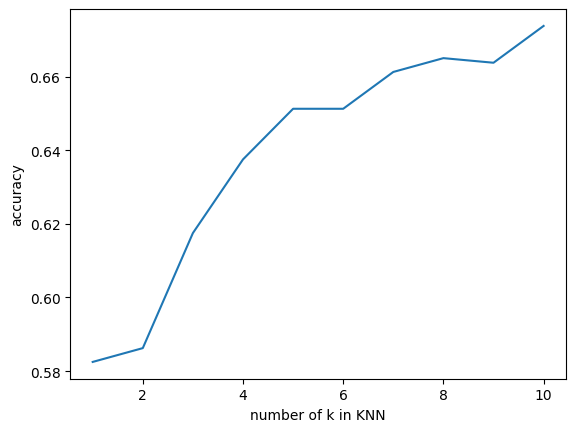

In [16]:
import matplotlib.pyplot as plt
acc = []
kh = []
for k in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    kh.append(k)

plt.plot(kh, acc)
plt.xlabel("number of k in KNN")
plt.ylabel("accuracy")


## Confusion Matrix

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [18]:
predicted_label = neigh.predict(X_train)
real_label = y_train

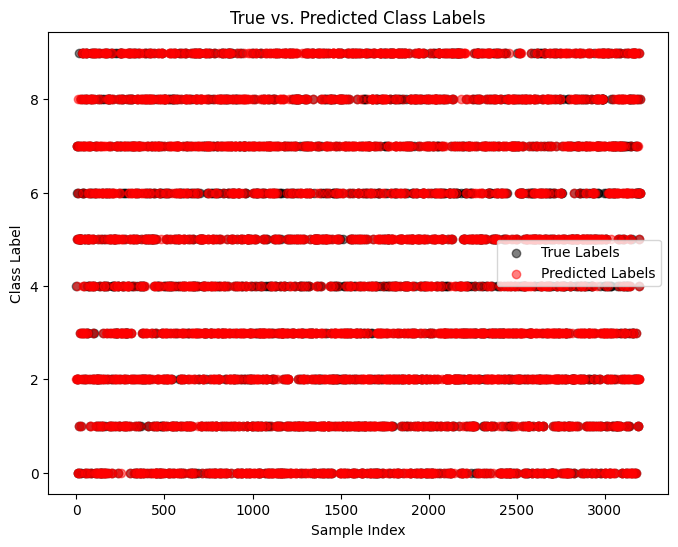

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(real_label)), real_label, color='black', label='True Labels', alpha=0.5)
plt.scatter(range(len(predicted_label)), predicted_label, color='red', label='Predicted Labels', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.title('True vs. Predicted Class Labels')
plt.legend()
plt.show()

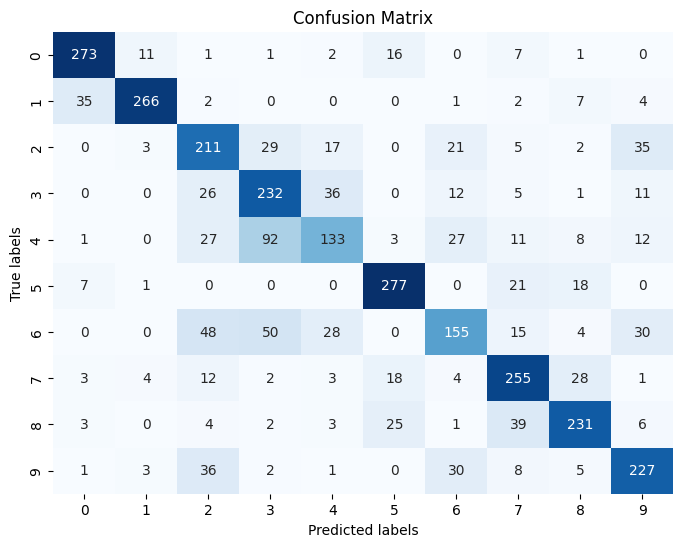

In [20]:
# Create confusion matrix
conf_matrix = confusion_matrix(real_label, predicted_label)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Plot accuracy per the number of data, that we use to work on it

C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pouya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:238: 

Text(0, 0.5, 'Accuracy')

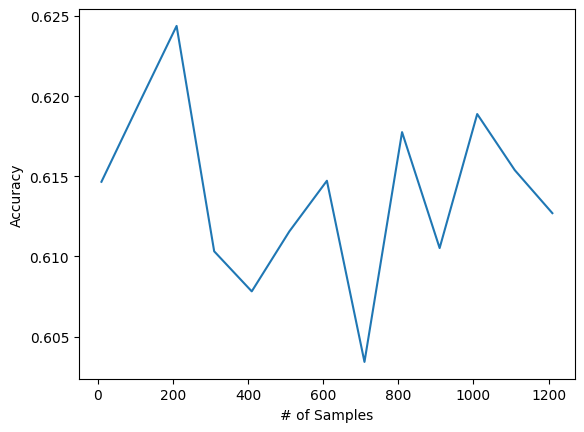

In [21]:
acc = []
sample_arr = []
k = 3

for range_of_sample in range(10,1300,100):
    sample_arr.append(range_of_sample)
    for i in range(10):
        for j in range(input_testing.shape[0]):
            try:
                if (output_testing[j] == i):
                    input_arr2 = np.delete(input_testing, slice(j+range_of_sample,j+2000), axis = 0)
                    output_arr2 = np.delete(output_testing, slice(j+range_of_sample,j+2000), axis = 0)
                    break
        
            except:
                pass

    X_train, X_test, y_train, y_test = train_test_split(input_arr2 , output_arr2, test_size=0.2, random_state=2)
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    



plt.plot(sample_arr, acc)
plt.xlabel("# of Samples")
plt.ylabel("Accuracy")